In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import time
%matplotlib inline

In [2]:
class Thermo_problem:
    def __init__(self, initial_f, left_f, right_f, f, D, x_range, t_range):
        self.initial_f = initial_f
        self.left_f = left_f
        self.right_f = right_f
        self.D = D
        self.x_range = x_range
        self.t_range = t_range
        self.f = f

In [3]:
def solve_diags_3(A, f):
    """Функция реализует метод прогонки СЛАУ.
    Принимает матрицу А левой части и вектор f правой части,
    необходимую точность. Возвращает вектор решения"""
    N = A.shape[0]
    d = f
    c = np.diagonal(A, offset=1)
    b = np.diagonal(A)
    a = np.diagonal(A, offset=-1)

    L = np.tril(A, k=-2)
    U = np.triu(A, k=2)
    if np.linalg.norm(L) > 0 or np.linalg.norm(U) > 0:
        print("Not 3x diagonal matrix!")
        return(-1)

    answer = [0] * N
    y = []
    y.append(b[0])
    alpha = []
    alpha.append(-c[0] / y[0])
    beta = []
    beta.append(d[0]/y[0])

    for i in range(1, N-1):
        y.append(b[i] + a[i-1] * alpha[-1])
        alpha.append(-c[i] / y[-1])
        beta.append((d[i] - a[i-1] * beta[-1]) / y[-1])
    y.append(b[N-1] + a[N-2] * alpha[-1])
    beta.append((d[N-1] - a[N-2] * beta[-1]) / y[-1])

    answer[-1] = beta[-1]
    for i in range(N-2, -1, -1):
        answer[i] = alpha[i] * answer[i+1] + beta[i]
    answer = np.array(answer)

    return(answer)

In [4]:
class Solve_Thermo:
    def __init__(self, problem):
        self.initial_f = problem.initial_f
        self.left_f = problem.left_f
        self.right_f = problem.right_f
        self.D = problem.D
        self.x_range = problem.x_range
        self.a = x_range[0]
        self.b = x_range[1]
        self.t_range = problem.t_range
        self.t0 = self.t_range[0]
        self.T = self.t_range[1]
        
    def solve_layer(self, prev_layer, n, grid, alpha, plot=False):
        N, M, h, tau, sigma = grid["N"], grid["M"], grid["h"], grid["tau"], grid["sigma"]
        x_arr = np.linspace(self.a, self.b, M+1)
        central_diag = np.array([1 + 2*sigma*alpha if m > 0 and m < M
                                else 1 for m in range(M+1)])
        lower_diag = np.array([ -sigma*alpha if m < M
                                else 0 for m in range(1, M+1)])
        upper_diag = np.array([ -sigma*alpha if m > 0 
                                else 0 for m in range(M)])
        matrix = np.diag(central_diag, k=0) + np.diag(lower_diag, k=-1) + np.diag(upper_diag, k=1)
        
        right_column = np.array([prev_layer[m] + sigma*(1-alpha)*
                                 (prev_layer[m+1] - 2*prev_layer[m] + prev_layer[m-1]) if m > 0 and m < M 
                                 else self.left_f((n+1)*tau) if m == 0 
                                 else self.right_f((n+1)*tau) for m in range(M+1)])
        right_column.transpose()
        
        next_layer = solve_diags_3(matrix, right_column)
        next_layer.transpose()
        
        return next_layer
    
    def solve(self, alpha, N, M, save_all = False, plot=True, delay=0.1):
        h = (self.b - self.a) / M
        tau = (self.T - self.t0) / N        
        sigma = tau * self.D / np.square(h)
        print("sigma: {}".format(sigma))
        x_arr = np.linspace(self.a, self.b, M+1)
        grid = {"N": N, "M": M, "h": h, "tau": tau, "sigma": sigma}         
        layer = self.initial_f(x_arr)
        
        solution = []
        if save_all:
            solution.append(layer)
            
        if plot:
            plt.axis([0, 100, 0, 1])
            
            
        for n in range(N):
            layer = self.solve_layer(layer, n, grid, alpha=alpha)
            if save_all:
                solution.append(layer)
            if plot:
                plt.plot(x_arr, layer, linewidth=1)
                plt.pause(delay)
        
        if plot:
            plt.show
        
        return np.array(solution)
            

In [112]:
def initial_1(x):
    output = np.array([100 for element in x])
    return output
def left_f_1(t):
    if t != 0:
        return 50
    else:
        return 100
def right_f_1(t):
    if t != 0:
        return 50
    else:
        return 100
def f_1(x, t):
    return 0
D = 0.01
x_range = (0, 1)
t_range = (0, 1)
problem_1 = Thermo_problem(initial_1, left_f_1, right_f_1, f_1, D, x_range, t_range)
solving = Solve_Thermo(problem_1)

In [113]:
N = 100
M = 100
alpha = 1
solution = solving.solve(alpha, N, M, save_all=True, plot=False, delay=0.01)

sigma: 1.0


Text(0.5, 0, 'U, temperature')

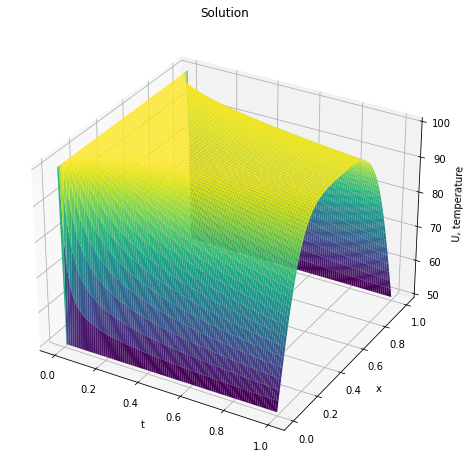

In [114]:
k = np.arange(0, M+1)
m = np.arange(0, M+1)
def arr_U(k, m):
    return solution[k, m]
fig = plt.figure(figsize = [8, 8])
ax = plt.axes(projection='3d')
X_0 = np.linspace(0, 1, M+1)
T_0 = np.linspace(0, 1, M+1)
X, T = np.meshgrid(X_0, T_0)
k, m = np.meshgrid(k, m)
data_plot = arr_U(k, m)

ax.plot_surface(X, T, data_plot, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Solution')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('U, temperature')

Presize solution

In [84]:
from numpy import square, power, sin, exp, pi, sqrt
import scipy

In [85]:
def kernel(x, t, D, L, y):
    return exp(-square(x - y)/ (4 * square(D) * t))

In [86]:
def presize_1D(x, t, C0, L, D):
    func = lambda y: kernel(x, t, D, L, y) 
    integral, error = scipy.integrate.quad(func, 0, L, epsabs=1e-6)
    return C0*integral/(2*D*sqrt(pi*t)) 

Text(0.5, 0, 'U, temperature')

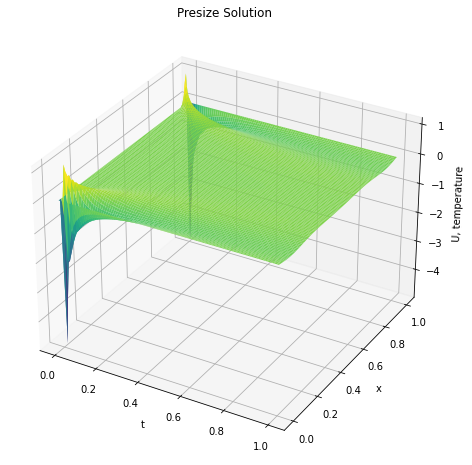

In [115]:
N, M = 100, 100
C0, L, D = 100, 1, sqrt(0.01)
x_band = np.linspace(0, 1, M+1)
t_band = np.linspace(0, 1, N+1)
presize = [[presize_1D(x, t, C0, L, D) for x in x_band] if t != 0 
           else [C0]*(M+1) for t in t_band]
presize = np.array(presize)

k = np.arange(0, M+1)
m = np.arange(0, M+1)
def arr_U(k, m):
    return presize[k, m] - solution[k, m]
fig = plt.figure(figsize = [8, 8])
ax = plt.axes(projection='3d')
X_0 = np.linspace(0, 1, M+1)
T_0 = np.linspace(0, 1, M+1)
X, T = np.meshgrid(X_0, T_0)
k, m = np.meshgrid(k, m)
data_plot = arr_U(k, m)

ax.plot_surface(X, T, data_plot, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Presize Solution')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('U, temperature')

In [88]:
from sklearn import linear_model

sigma: 0.25
sigma: 0.5624999999999999
sigma: 1.0
sigma: 1.5625000000000002
sigma: 2.2499999999999996
sigma: 4.0
sigma: 8.999999999999998
Порядок сходимости 0.06021


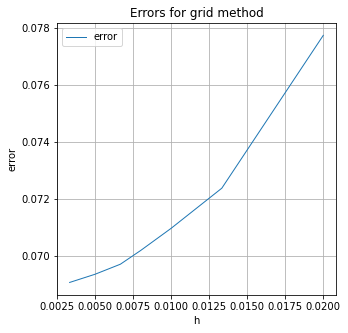

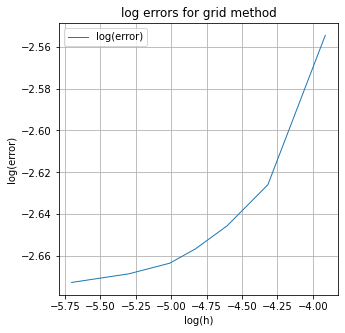

In [116]:
N = 100
M_band = np.array([50, 75, 100, 125, 150, 200, 300])

h_band = 1 / M_band
Errors = []
for M in M_band:
    alpha = 1
    solution = solving.solve(alpha, N, M, save_all=True, plot=False, delay=0.01)
    x_band = np.linspace(0, 1, M+1)
    t_band = np.linspace(0, 1, N+1)
    presize = [[presize_i(x, t, C0, L, D) for x in x_band] if t != 0 else [C0]*(M+1) for t in t_band]
    presize = np.array(presize)
    error = np.linalg.norm(presize[-1,:]-solution[-1, :], ord=np.inf)
    Errors.append(error)
    
plt.figure(figsize = [5, 5])
plt.title('Errors for grid method')            
plt.plot(h_band, Errors, label='error', linewidth=1)
plt.grid()
plt.xlabel('h')
plt.ylabel('error')
plt.legend()

plt.figure(figsize = [5, 5])
plt.title('log errors for grid method')            
plt.plot(np.log(h_band), np.log(Errors), label='log(error)', linewidth=1)
plt.grid()
plt.xlabel('log(h)')
plt.ylabel('log(error)')
plt.legend()

linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(np.log(h_band).reshape(-1, 1), np.log(Errors))
print('Порядок сходимости',np.round(linear_regressor.coef_[0], 5))

In [ ]:
def presize_2D(x, t, C0, L, D):
    func = lambda y: kernel(x, t, D, L, y) 
    integral, error = scipy.integrate.dblquad(func, 0, L, 0, L, epsabs=1e-3)
    return C0*integral/square((2*D*sqrt(pi*t))) 

In [ ]:
class Thermo_problem_2D:
    def __init__(self, initial_f, edges_conditions, f, D, a, t_range):
        self.initial_f = initial_f
        self.left_f = edges_conditions["left_f"]
        self.right_f = edges_conditions["right_f"]
        self.down_f = edges_conditions["down_f"]
        self.up_f = edges_conditions["up_f"]
        self.D = D
        self.a = a
        self.t_range = t_range
        self.f = f

In [ ]:
class Solve_Thermo_2D:
    def __init__(self, problem):
        self.initial_f = problem.initial_f
        self.left_f = problem.left_f
        self.right_f = problem.right_f
        self.down_f = problem.down_f
        self.up_f = problem.up_f
        self.D = problem.D        
        self.a = problem.a        
        self.t_range = problem.t_range
        self.t0 = self.t_range[0]
        self.T = self.t_range[1]
        
    def solve_layer(self, layer, n, grid, plot=False, show_freq=100, debug=False):
        N, M, h, tau, sigma = grid["N"], grid["M"], grid["h"], grid["tau"], grid["sigma"]
        x_arr, y_arr, t_arr = grid["x_arr"], grid["y_arr"], grid["t_arr"]
        
        if n % show_freq == 0 and debug:
            print(self.left_f(t_arr[0], y_arr[M//2]))
            print(np.round(layer))
        
        next_layer = [[layer[i, j] + sigma*(layer[i+1, j] - 4*layer[i,j] + 
                       layer[i-1, j] + layer[i, j+1] + layer[i, j-1]) if i > 0 and i < M and j > 0 and j < M
                       
                       else self.right_f(t_arr[n+1], y_arr[j]) if i == M
                       else self.left_f(t_arr[n+1], y_arr[j]) if i == 0
                       else self.down_f(t_arr[n+1], x_arr[i]) if j == 0
                       else self.up_f(t_arr[n+1], x_arr[i]) for j in range(M+1)] 
                       for i in range(M+1)]
              
        return np.array(next_layer) 
    
    def solve(self, N, M, save_all = False, plot=True, show_freq=100, debug=False):
        h = self.a / M
        tau = (self.T - self.t0) / N        
        sigma = tau * self.D / np.square(h)
        print("sigma(Courant number): {}".format(sigma))
        x_arr = np.linspace(0, self.a, M+1)
        y_arr = np.linspace(0, self.a, M+1)
        t_arr = np.linspace(self.t0, self.T, N+1)
        grid = {"N": N, "M": M, "h": h, "tau": tau, "sigma": sigma, 
                "x_arr": x_arr, "y_arr": y_arr, "t_arr": t_arr} 
    
        layer = [[initial(x_arr[0], y_arr[0]) if i > 0 and i < M and j > 0 and j < M
                  else self.left_f(t_arr[0], y_arr[j]) if i == 0
                  else self.right_f(t_arr[0], y_arr[j]) if i == M
                  else self.down_f(t_arr[0], x_arr[i]) if j == 0
                  else self.up_f(t_arr[0], x_arr[i]) for j in range(M+1)] 
                  for i in range(M+1)]
        layer = np.array(layer)
        
        success = 0
        for n in range(N):
            layer = self.solve_layer(layer, n, grid, show_freq=show_freq, debug=debug)
        
            if n % show_freq == 0 or n == N:
                k = np.arange(0, M+1)
                m = np.arange(0, M+1)
                def arr_U(k, m):
                    return layer[k, m]
                fig = plt.figure(figsize = [8, 8])
                ax = plt.axes(projection='3d')
                X_0 = np.linspace(0, a, M+1)
                Y_0 = np.linspace(0, a, M+1)
                X, Y = np.meshgrid(X_0, Y_0)
                k, m = np.meshgrid(k, m)
                data_plot = arr_U(k, m)

                ax.plot_surface(X, Y, data_plot, rstride=1, cstride=1,
                                cmap='viridis', edgecolor='none')
                ax.set_title('Solution in moment t={}'.format(n*tau))
                ax.set_xlabel('y')
                ax.set_ylabel('x')
                ax.set_zlabel('U')
            
            if ((100*n)//N) % 10 == 0 and success !=((100*n)//N): 
                print("Computed {}% of task".format((100*n)//N))
                success = ((100*n)//N)
            
        
        return layer   
        

In [ ]:
def initial(x, y):
    return 100
def left_f(t, y):
    return 0
def right_f(t, y):
    return 0
def up_f(t, x):
    return 0
def down_f(t, x):
    return 0
def f(x, y):
    return 0
a = 1
D = 0.05
t_range = (0, 1)
edges_conditions = {"left_f": left_f, "right_f": right_f, "down_f": down_f, "up_f": up_f}
problem = Thermo_problem_2D(initial, edges_conditions, f, D, a, t_range)
solving = Solve_Thermo_2D(problem)
N, M = 500, 100
last_layer = solving.solve(N, M, show_freq=100)

In [ ]:
C0, L, a = 100, 1, 0.1
x_band = np.linspace(0, 1, M+1)
t_band = np.linspace(0, 1, N+1)
presize = [[presize_i(x, t, C0, L, a) for x in x_band] if t != 0 else [C0]*(M+1) for t in t_band]
presize = np.array(presize)

k = np.arange(0, M+1)
m = np.arange(0, M+1)
def arr_U(k, m):
    return presize[k, m]
fig = plt.figure(figsize = [8, 8])
ax = plt.axes(projection='3d')
X_0 = np.linspace(0, 1, M+1)
T_0 = np.linspace(0, 1, M+1)
X, T = np.meshgrid(X_0, T_0)
k, m = np.meshgrid(k, m)
data_plot = arr_U(k, m)

ax.plot_surface(X, T, data_plot, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Presize Solution')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('U, temperature')